In [0]:
import tensorflow as tf

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Volt")
    plt.grid(True)

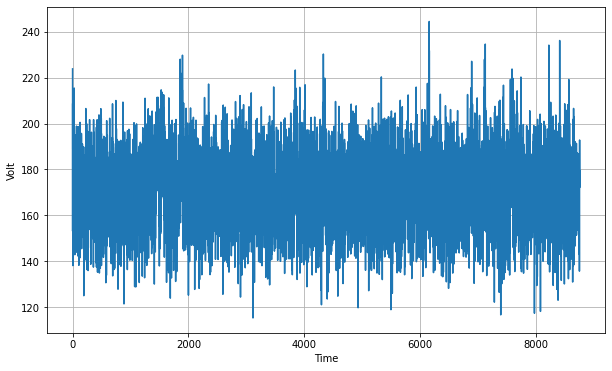

In [11]:
import csv
time_step = []
temps = []

with open('/tmp/telemetry.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 6500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=168, batch_size=24, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=3e-7)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
264/264 [==============================] - 5s 19ms/step - loss: 55.6848 - mae: 56.1813
Epoch 2/150
264/264 [==============================] - 5s 19ms/step - loss: 15.5814 - mae: 16.0733
Epoch 3/150
264/264 [==============================] - 5s 19ms/step - loss: 15.2433 - mae: 15.7353
Epoch 4/150
264/264 [==============================] - 5s 19ms/step - loss: 14.9737 - mae: 15.4653
Epoch 5/150
264/264 [==============================] - 5s 19ms/step - loss: 14.7734 - mae: 15.2650
Epoch 6/150
264/264 [==============================] - 5s 19ms/step - loss: 14.6330 - mae: 15.1247
Epoch 7/150
264/264 [==============================] - 5s 19ms/step - loss: 14.5189 - mae: 15.0107
Epoch 8/150
264/264 [==============================] - 5s 19ms/step - loss: 14.4225 - mae: 14.9143
Epoch 9/150
264/264 [==============================] - 5s 19ms/step - loss: 14.3361 - mae: 14.8279
Epoch 10/150
264/264 [==============================] - 5s 19ms/step - loss: 14.2569 - mae: 14.7488
Epoch 11/

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

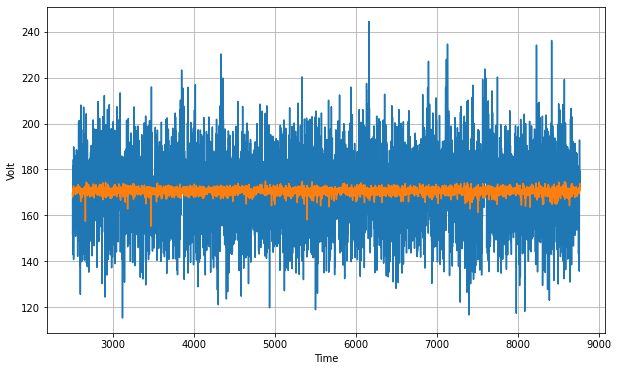

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [0]:
print(rnn_forecast)